# **MODEL**

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import urllib.request

In [ ]:
url = "https://drive.google.com/uc?id=15fyGgYoLh0TjKuPwRgA6suaTZhxV67Iw"
filename = "ngirit_dataset.csv"
urllib.request.urlretrieve(url, filename)

('ngirit_dataset.csv', <http.client.HTTPMessage at 0x7fa388a229b0>)

In [ ]:
# Load and preprocess your dataset
data = pd.read_csv(filename)

In [ ]:
data = data.drop('merchant_area',axis=1).replace(to_replace = 'NAN', value=np.NaN)
data['rating'] = pd.to_numeric(data['rating'])
data['rating'].fillna(float(data['rating'].mean()),inplace=True)

In [ ]:
category = np.array(data['sub_category'].value_counts().index)
unique_category = []
for kat in category:
  split = kat.split("/")
  for spl in split:
    if spl not in unique_category:
      unique_category.append(spl)

In [ ]:
unique_category

['Jajanan',
 'Minuman',
 'Cepat saji',
 'Roti',
 'Kopi',
 'Sweets',
 'Jepang',
 'Barat',
 'Aneka nasi',
 'Korea',
 'Martabak',
 'Ayam & bebek',
 'Pizza dan pasta',
 'Bakmie',
 'Timur Tengah',
 'Bakso & soto',
 'Chinese',
 'Seafood',
 'Sate']

In [ ]:
data.head

<bound method NDFrame.head of            merchant_name  latitude   longitude  rating main_category  \
0      330 Kopi, Ciledug -6.238121  106.716895     3.6       Makanan   
1      330 Kopi, Ciledug -6.238121  106.716895     3.6       Makanan   
2      330 Kopi, Ciledug -6.238121  106.716895     3.6       Makanan   
3      330 Kopi, Ciledug -6.238121  106.716895     3.6       Makanan   
4      330 Kopi, Ciledug -6.238121  106.716895     3.6       Makanan   
...                  ...       ...         ...     ...           ...   
10953      XXI Cafe, PGC -6.262136  106.865563     4.2       Minuman   
10954      XXI Cafe, PGC -6.262136  106.865563     4.2       Minuman   
10955      XXI Cafe, PGC -6.262136  106.865563     4.2       Minuman   
10956      XXI Cafe, PGC -6.262136  106.865563     4.2       Minuman   
10957      XXI Cafe, PGC -6.262136  106.865563     4.2       Minuman   

      sub_category                     product    price  
0          Jajanan         Pisang Lumer Coklat 

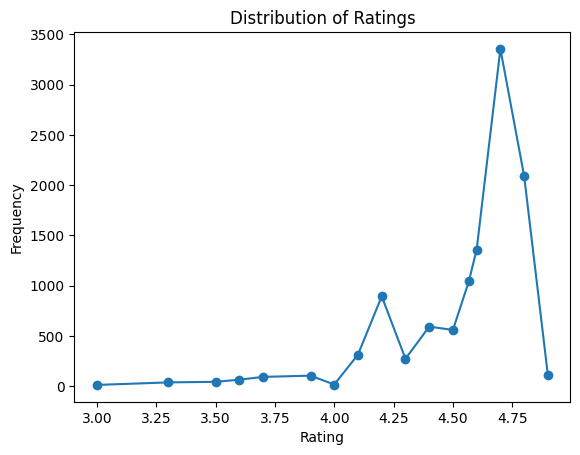

In [ ]:
# Ambil data rating dari dataset
ratings = data['rating']

# Hitung frekuensi masing-masing rating
rating_counts = ratings.value_counts().sort_index()

# Buat grafik titik garis
plt.plot(rating_counts.index, rating_counts.values, marker='o', linestyle='-')

# Atur label dan judul
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Ratings')

# Tampilkan grafik
plt.show()

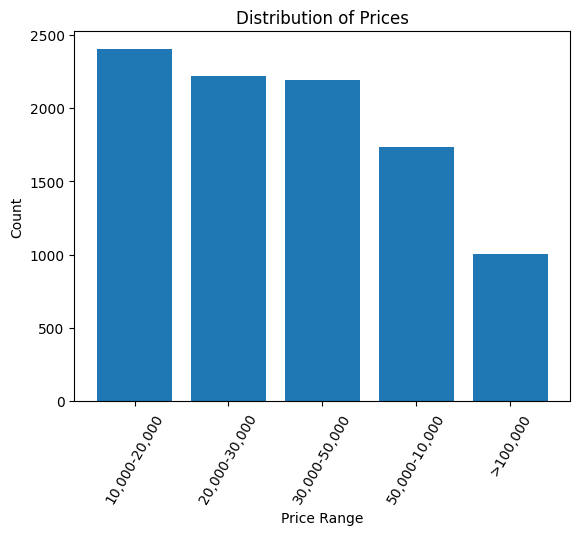

In [ ]:
# Menentukan rentang harga
price_ranges = ['10,000-20,000', '20,000-30,000', '30,000-50,000', '50,000-10,000', '>100,000']

# Mengelompokkan data berdasarkan rentang harga
data['price_range'] = pd.cut(data['price'], bins=[10000, 20000, 30000, 50000, 100000, float('inf')], labels=price_ranges)

# Menghitung jumlah entri dalam setiap rentang harga
price_counts = data['price_range'].value_counts().sort_index()

# Membuat grafik batang
plt.bar(price_counts.index, price_counts.values)

# Mengatur label dan judul
plt.xlabel('Price Range')
plt.ylabel('Count')
plt.title('Distribution of Prices')

# Atur rotasi label jika diperlukan
plt.xticks(rotation=60)

# Menampilkan grafik
plt.show()

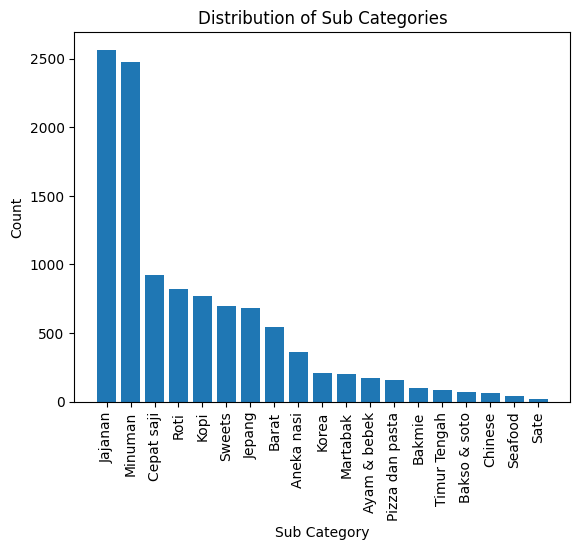

In [ ]:
# Ambil data sub kategori dari dataset
sub_categories = data['sub_category']

# Hitung jumlah kemunculan setiap sub kategori
sub_category_counts = sub_categories.value_counts()

# Buat grafik batang
plt.bar(sub_category_counts.index, sub_category_counts.values)

# Atur label dan judul
plt.xlabel('Sub Category')
plt.ylabel('Count')
plt.title('Distribution of Sub Categories')

# Atur rotasi label jika diperlukan
plt.xticks(rotation=90)

# Tampilkan grafik
plt.show()

In [ ]:
# Encode the target variable
label_encoder = LabelEncoder()
data['sub_category_encoded'] = label_encoder.fit_transform(data['sub_category'])

In [ ]:
# Menggabungkan kolom yang relevan untuk membuat teks yang akan digunakan untuk perhitungan kesamaan kosinus
data['combined_features'] = data[['merchant_name', 'main_category', 'sub_category', 'product']].apply(lambda x: ' '.join(x), axis=1)

In [ ]:
# Membuat matriks kecocokan kata kunci menggunakan CountVectorizer
cv = CountVectorizer()
X = cv.fit_transform(data['combined_features'])

In [ ]:
# Split the dataset into train and test sets
y = data['sub_category_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Convert the sparse matrix to a dense matrix
X_train = X_train.toarray()
X_test = X_test.toarray()

In [ ]:
# Define the model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.3),
                          input_shape=(X_train.shape[1],)),
    # tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    # tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dense(len(np.unique(y_train)), activation='softmax')
])

In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
274/274 [==============================] - 3s 10ms/step - loss: 3.7189 - accuracy: 0.5499 - val_loss: 1.6369 - val_accuracy: 0.6770
Epoch 2/10
274/274 [==============================] - 3s 12ms/step - loss: 1.4980 - accuracy: 0.7725 - val_loss: 1.3804 - val_accuracy: 0.8079
Epoch 3/10
274/274 [==============================] - 4s 15ms/step - loss: 1.2890 - accuracy: 0.8701 - val_loss: 1.2141 - val_accuracy: 0.9019
Epoch 4/10
274/274 [==============================] - 4s 13ms/step - loss: 1.1440 - accuracy: 0.9057 - val_loss: 1.0976 - val_accuracy: 0.9110
Epoch 5/10
274/274 [==============================] - 3s 11ms/step - loss: 1.0370 - accuracy: 0.9227 - val_loss: 0.9984 - val_accuracy: 0.9092
Epoch 6/10
274/274 [==============================] - 4s 16ms/step - loss: 0.9539 - accuracy: 0.9324 - val_loss: 0.9313 - val_accuracy: 0.9252
Epoch 7/10
274/274 [==============================] - 4s 15ms/step - loss: 0.8842 - accuracy: 0.9383 - val_loss: 0.8697 - val_accuracy: 0.9370

In [ ]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test, y_test)
print('Accuracy:', accuracy)

69/69 [==============================] - 1s 13ms/step - loss: 0.7254 - accuracy: 0.9425
Accuracy: 0.9425182342529297


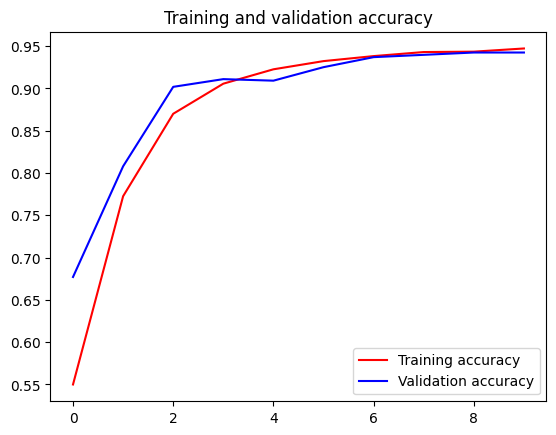

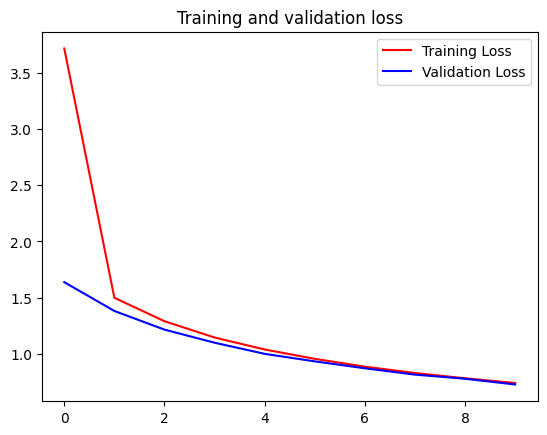

In [ ]:
# Plot the chart for accuracy and loss on both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# **TESTING**

In [ ]:
# Define a function to predict the output product and rating
def predict_product_and_rating(price, sub_category):
    # Create a dataframe with the input data
    input_data = pd.DataFrame({'price': [price], 'sub_category': [sub_category]})
    
    # Preprocess the input data
    input_data['rating'] = data['rating'].mean()  # Set the rating as the average rating in the dataset
    input_data['sub_category_encoded'] = label_encoder.transform(input_data['sub_category'])
    input_data['combined_features'] = input_data[['sub_category']].apply(lambda x: ' '.join(x), axis=1)
    
    # Transform the input data using the CountVectorizer
    input_features = cv.transform(input_data['combined_features']).toarray()
    
    # Make predictions using the trained model
    predictions = model.predict(input_features)
    
    # Get the predicted class label and corresponding rating
    predicted_class = np.argmax(predictions)
    predicted_rating = data[data['sub_category_encoded'] == predicted_class]['rating'].values[0]
    predicted_product = data[data['sub_category_encoded'] == predicted_class]['product'].values[0]
    
    return predicted_product, predicted_rating

In [ ]:
# Test the model with input price and sub category
price = 100000
sub_category = 'Minuman'
predicted_product, predicted_rating = predict_product_and_rating(price, sub_category)

# Print the predicted output
print('Predicted Product:', predicted_product)
print('Predicted Rating:', predicted_rating)

1/1 [==============================] - 0s 64ms/step
Predicted Product: Yubari Float
Predicted Rating: 4.8
